# Multimodal Clustering Analysis

Sep 2019  
Dongmin Kim
[underkoo@kaist.ac.kr](mailto:underkoo@kaist.ac.kr)

**Expected input data:**
Process 900 dim latent feature of multi-modal instagram posts

**What this script does:**  
Explorative data analysis on the mult-modal latent. Checks for feature correlation (features = 900 dimesnsions), applies and visualized PCA, applies t-SNE on different data (raw, PCA, etc).


In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
import os
import copy
import collections
import seaborn as sns; sns.set()
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import Birch, SpectralClustering, AffinityPropagation, AgglomerativeClustering, MiniBatchKMeans, KMeans, DBSCAN, OPTICS
import matplotlib.colors as colors
import math
import time
import config

In [2]:
# magic line to have in-notebook interactive plots
%matplotlib notebook

In [ ]:
#If you want to use a korean words, unblock it!
# path_gothic = './fonts/NanumBarunGothic.ttf'
# fontprop1 = fm.FontProperties(fname=path_gothic, size=3)

In [3]:
CONFIG = config.Config

## load latent feature

In [4]:
# load raw data
target_csv = 'latent_instagram0830_no_decode'
df_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, target_csv + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print('complete csv shape: ' + str(df_data.shape))
print(df_data.iloc[:100])

complete csv shape: (80721, 1000)
                    0         1         2         3         4         5  \
short_code                                                                
B0-2hwnAUC7 -0.365889  0.275629  0.155383  0.059173  0.140281 -0.306930   
B0-3GYUJu9-  0.135777 -0.116326 -0.674513 -0.545554 -0.152085 -0.204046   
B0-9JKVFedH  0.488348  0.201079  0.176099 -0.100552 -0.169656 -0.056953   
B0-CPc3FpnC  0.488731  0.047226  0.203471 -0.086739 -0.461612  0.094273   
B0-D-SzhwCO -0.076097 -0.274166 -0.177092  0.127397  0.263339 -0.099455   
B0-JKv-nxDa -0.654098  0.813878  0.596315  0.485679 -0.748256 -0.095551   
B0-OOlUAdVQ -0.502742  0.666737  0.479848  0.182203 -0.667802 -0.263075   
B0-QMh0lEHH  0.883170 -0.526551  0.608230  0.052084  0.475046 -0.361761   
B0-R0vhF4qE  0.276804 -0.536355 -0.394224  0.686316 -0.615330 -0.226766   
B0-WfPbHN_A -0.338739 -0.848379  0.166507 -0.474800  0.225473  0.113707   
B0-duGsg4l_  0.100878 -0.190585  0.024478  0.275958  0.188346 -0.0

In [5]:
print(df_data.describe())

                  0             1             2             3             4  \
count  80721.000000  80721.000000  80721.000000  80721.000000  80721.000000   
mean      -0.033833     -0.045954     -0.049418      0.035822     -0.012587   
std        0.332001      0.336003      0.310794      0.311531      0.320437   
min       -0.978976     -0.978166     -0.980646     -0.958579     -0.990297   
25%       -0.251790     -0.269406     -0.242083     -0.149571     -0.216647   
50%       -0.046385     -0.054089     -0.064194      0.074628     -0.019906   
75%        0.169850      0.164992      0.125652      0.227093      0.189246   
max        0.972333      0.984002      0.972156      0.985468      0.968332   

                  5             6             7             8             9  \
count  80721.000000  80721.000000  80721.000000  80721.000000  80721.000000   
mean      -0.096638     -0.026491     -0.009474     -0.018367     -0.032317   
std        0.290694      0.296715      0.338411    

In [ ]:
# data seems to be well normalized to mean or median = 0 and std = 1
plt.figure()
df_data.boxplot()

In [6]:
#df_normalized = df_data.div((np.sqrt(np.sum(np.square(df_data), axis=1))), axis=0)
#df_normalized.to_csv(os.path.join(CONFIG.CSV_PATH, 'normalized_' + target_csv + '.csv'), encoding='utf-8-sig')
df_normalized = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'normalized_' + target_csv + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print('complete csv shape: ' + str(df_normalized.shape))
print(df_normalized.iloc[:100])

complete csv shape: (80721, 1000)
                    0         1         2         3         4         5  \
short_code                                                                
B0-2hwnAUC7 -0.049785  0.037504  0.021142  0.008051  0.019087 -0.041763   
B0-3GYUJu9-  0.013983 -0.011980 -0.069463 -0.056183 -0.015662 -0.021013   
B0-9JKVFedH  0.057829  0.023811  0.020853 -0.011907 -0.020090 -0.006744   
B0-CPc3FpnC  0.037340  0.003608  0.015546 -0.006627 -0.035269  0.007203   
B0-D-SzhwCO -0.011986 -0.043184 -0.027894  0.020067  0.041479 -0.015665   
B0-JKv-nxDa -0.036420  0.045317  0.033203  0.027043 -0.041663 -0.005320   
B0-OOlUAdVQ -0.043654  0.057894  0.041666  0.015821 -0.057987 -0.022843   
B0-QMh0lEHH  0.060047 -0.035801  0.041354  0.003541  0.032299 -0.024596   
B0-R0vhF4qE  0.022481 -0.043561 -0.032017  0.055740 -0.049975 -0.018417   
B0-WfPbHN_A -0.025266 -0.063279  0.012419 -0.035414  0.016818  0.008481   
B0-duGsg4l_  0.016731 -0.031610  0.004060  0.045770  0.031239 -0.0

In [ ]:
print(np.sqrt(np.sum(np.square(df_normalized), axis=1)))

In [ ]:
print(df_normalized.describe())

In [ ]:
# data seems to be well normalized to mean or median = 0 and std = 1
plt.figure()
df_normalized.boxplot()

## PCA as dimensionality reduction

In [19]:
# PCA
pca = PCA(n_components=300)
df_pca_data = pd.DataFrame(pca.fit_transform(df_data))
df_pca_data.columns = ['PC' + str(i) for i in range(df_pca_data.shape[1])]
df_pca_data.index = df_data.index
print('singular_values_:\n' + str(pca.singular_values_))
print('components_:\n' + str(pca.components_))

# create PCA transformation DF
df_pca_transformation = pd.DataFrame(pca.components_).transpose()
df_pca_transformation.columns = ['PC' + str(i) for i in range(1, pca.n_components_ + 1)]
df_pca_transformation.index = df_data.columns
#print(df_pca_transformation)

singular_values_:
[376.31013415 260.20835975 240.19689998 221.56851992 211.37081062
 208.9340517  201.72544828 198.97851664 197.42569812 193.85045133
 192.02192585 189.67832506 189.43831677 187.38439514 186.30629645
 185.43625812 183.40097692 183.02309657 181.52435654 180.7156029
 179.45814367 179.01358674 177.35349714 176.79642508 175.57390079
 174.30993619 173.11496564 173.01838239 172.45531021 171.51270353
 170.66176903 170.10268132 169.64722343 168.85035465 168.09929722
 167.05219435 166.82196183 165.44188167 164.82487985 164.35885835
 163.8301251  163.57932195 163.48233471 162.61956466 161.51008067
 161.10827816 160.85003352 160.46014695 159.93829523 159.50493646
 158.71189778 158.52147983 158.38500306 157.29196973 157.15957103
 156.57636168 156.23994393 155.56139321 155.07488974 154.78834802
 154.71098619 153.87896298 153.10439617 152.73004173 152.08413964
 151.79096372 151.59333731 151.34465103 150.67006928 150.50890516
 150.04654816 149.93673722 149.25927861 148.61574937 148.40

<IPython.core.display.Javascript object>


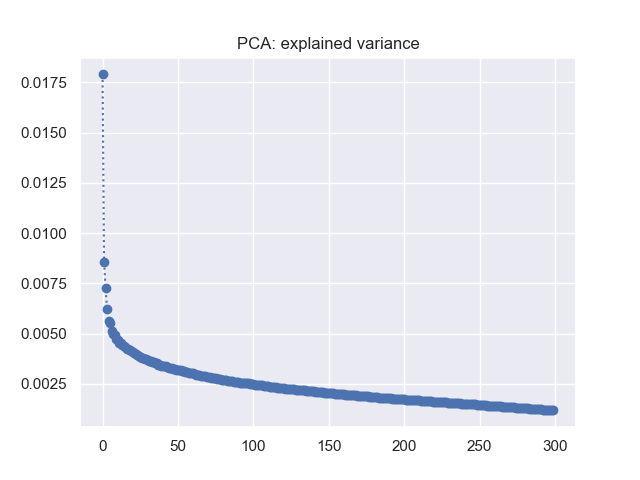

<IPython.core.display.Javascript object>


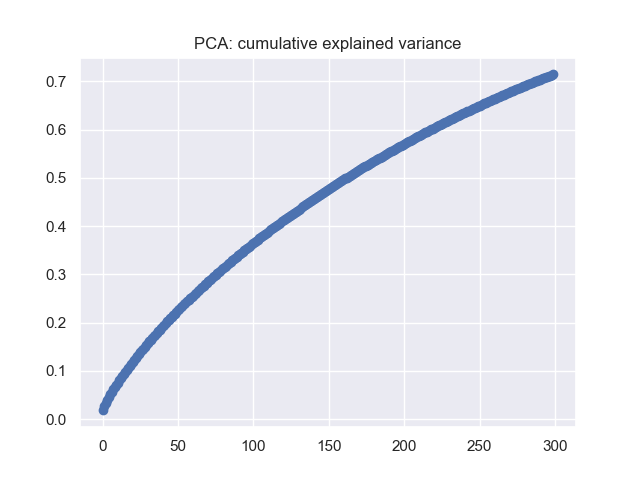

Text(0.5, 1.0, 'PCA: cumulative explained variance')

In [20]:
# PCA: plot variance explained
plt.figure()
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle=':')
plt.title('PCA: explained variance')

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle=':')
plt.title('PCA: cumulative explained variance')

In [8]:
def scatterplot_pointlabels(df_twocols, markersize=None):
    # basic scatterplot
    fig = plt.figure()
    plt.plot(df_twocols.iloc[:, 0], df_twocols.iloc[:, 1], marker='.', linestyle='None', markersize=markersize)

In [ ]:
# plot PC dimensions
for dimen1 in range(0, 5):
    for dimen2 in range(dimen1 + 1, 5):
        # subset dataframe to the PC columns we need
        df_tmp = df_pca_data.iloc[:, [dimen1, dimen2]]
        
        # plot without labels
        scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        plt.xlabel(df_tmp.columns[0])
        plt.ylabel(df_tmp.columns[1])
        
        # plot with labels
        #scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        #plt.xlabel(df_tmp.columns[0])
        #plt.ylabel(df_tmp.columns[1])

In [22]:
df_pca_data.to_csv(os.path.join(CONFIG.CSV_PATH, 'pca_' + target_csv + '.csv'), encoding='utf-8-sig')
#df_pca_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'pca_' + target_csv + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print(df_pca_data.iloc[:100])

                  PC0       PC1       PC2       PC3       PC4       PC5  \
short_code                                                                
B0-2hwnAUC7 -1.542946 -0.414940 -0.047337 -0.972658  0.742543  0.835032   
B0-3GYUJu9- -0.277848 -0.572088 -1.648396 -0.050485 -0.003382  0.096683   
B0-9JKVFedH -0.914425 -0.079793 -0.713200 -0.178699 -0.453992  0.706007   
B0-CPc3FpnC  0.868865 -0.773250 -0.952161 -0.783303  0.514649  0.004491   
B0-D-SzhwCO -1.189198 -0.552109  0.723576  0.319567 -0.448222 -1.037946   
B0-JKv-nxDa  3.441960 -0.818159  1.871981  1.170608 -0.109500  2.650990   
B0-OOlUAdVQ -0.291937  2.066809  1.293729 -1.771457 -1.239321  1.163578   
B0-QMh0lEHH  2.636548 -0.915688 -0.017909 -0.465152 -0.060457  0.382645   
B0-R0vhF4qE  1.098710 -0.540939 -0.047875 -0.652133  0.215056 -0.513087   
B0-WfPbHN_A  2.514281 -0.754071 -0.340617 -0.877257  0.506614 -0.983133   
B0-duGsg4l_ -1.196490 -0.827425  0.347110 -0.651692  0.030004  0.130122   
B0-efNMhicQ -0.303463  0.

## Downsample

In [ ]:
def downsampling(df_data, num_samples=100):
#     idx = int(len(df_data)/num_samples)
#     idx_list = [x for x in range(0, len(df_data), idx)]
#     return df_data.iloc[idx_list]
    return df_data.sample(num_samples)

In [ ]:
ds_data = downsampling(df_data, 10000)

In [ ]:
#ds_data.to_csv(os.path.join(CONFIG.CSV_PATH, 'ds_' + target_dataset + '.csv'), encoding='utf-8-sig')
ds_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'ds_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print(ds_data)

## t-SNE

In [9]:
def do_tsne(tsne_object, data_to_pass):
    data_tsne = pd.DataFrame(tsne_object.fit_transform(data_to_pass))
    data_tsne.index = data_to_pass.index
    data_tsne.columns = [['tsne1', 'tsne2']]
    return data_tsne

In [23]:
# on pca
# TODO tune the learning rate and the iterations (rest should be ok i guess)
lr_list = [20, 100, 200]
perp_list = [50, 200, 500, 1000, 2000]
for lr in lr_list:
    for perp in perp_list:     
        start_time = time.time()
        #tsne_pca = do_tsne(TSNE(n_components=2, perplexity=50, early_exaggeration=12.0, learning_rate=100, n_iter=5000, random_state=42, verbose=1), df_pca_data)
        tsne_pca = do_tsne(MulticoreTSNE(n_components=2, perplexity=perp, learning_rate=lr, n_iter=2000, random_state=42, n_jobs=4, verbose=1), df_pca_data)
        print("time elapsed: " + str(time.time()-start_time) + " lr: " + str(lr) + " perp: " + str(perp))
        #scatterplot_pointlabels(tsne_pca, 0.2)
        #plt.title('t-SNE on PCA data lr: ' + str(lr) + ' perp: ' + str(perp) )
        #plt.savefig(os.path.join(CONFIG.SVG_PATH, 'tsne_pca_' + target_csv + '_' + str(lr) + '_' + str(perp) + '.svg'))
        tsne_pca.to_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_pca_' + target_csv + '_' + str(lr) + '_' + str(perp) + '.csv'), encoding='utf-8-sig')

time elapsed: 1597.7419772148132 lr: 20 perp: 50
time elapsed: 2017.0952022075653 lr: 20 perp: 200
time elapsed: 2897.4921011924744 lr: 20 perp: 500
time elapsed: 4699.482710599899 lr: 20 perp: 1000
time elapsed: 10397.900932312012 lr: 20 perp: 2000
time elapsed: 1684.7538590431213 lr: 100 perp: 50
time elapsed: 2059.1541051864624 lr: 100 perp: 200
time elapsed: 3091.885588645935 lr: 100 perp: 500
time elapsed: 5156.630834817886 lr: 100 perp: 1000
time elapsed: 10153.776274442673 lr: 100 perp: 2000
time elapsed: 1667.446518421173 lr: 200 perp: 50
time elapsed: 2012.2202367782593 lr: 200 perp: 200
time elapsed: 2954.0428264141083 lr: 200 perp: 500
time elapsed: 4978.573520898819 lr: 200 perp: 1000
time elapsed: 10038.900278806686 lr: 200 perp: 2000


<IPython.core.display.Javascript object>


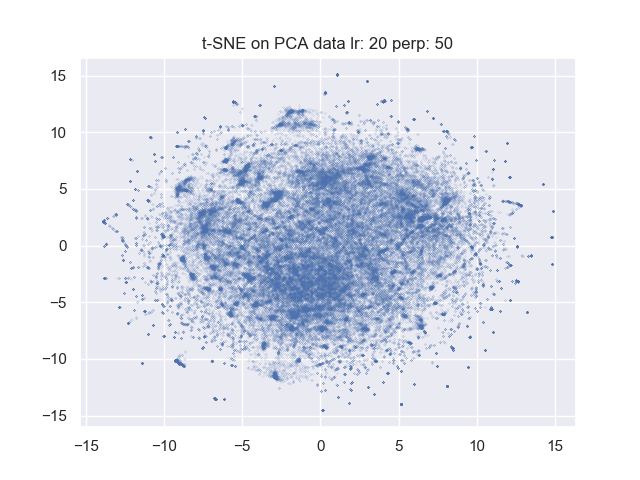

<IPython.core.display.Javascript object>


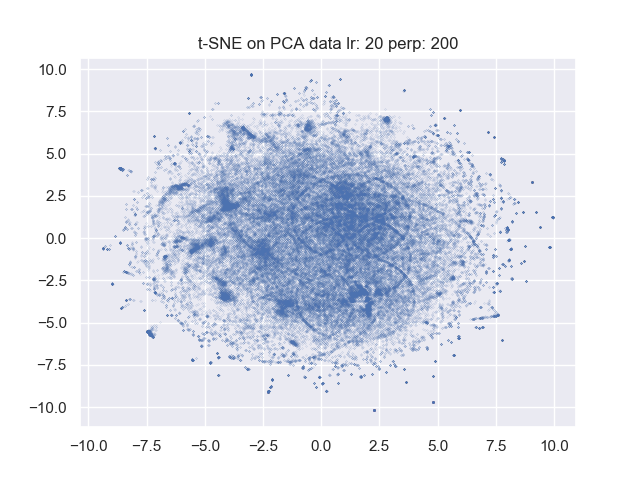

<IPython.core.display.Javascript object>


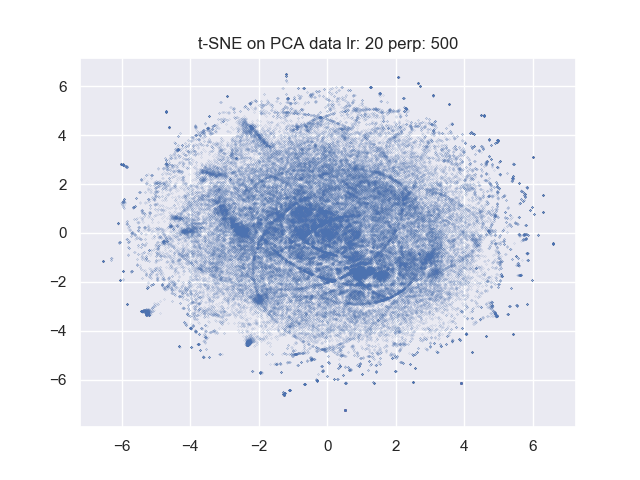

<IPython.core.display.Javascript object>


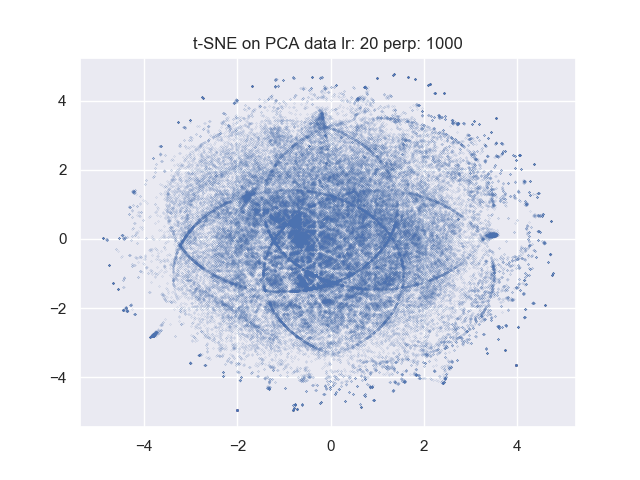

<IPython.core.display.Javascript object>


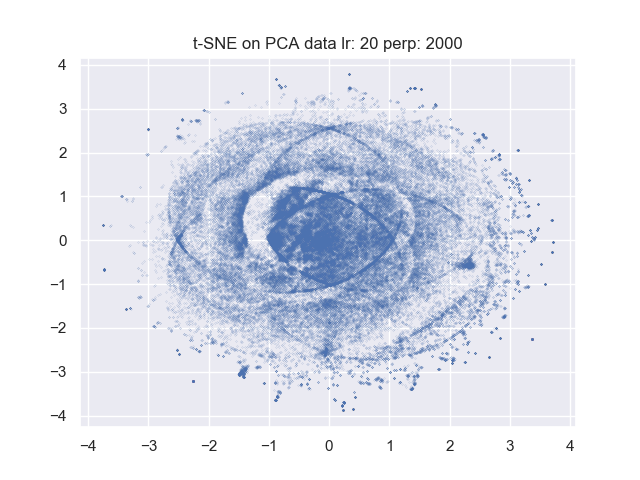

<IPython.core.display.Javascript object>


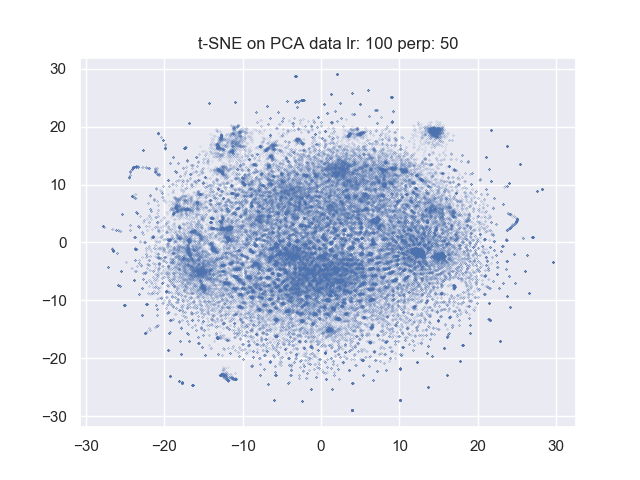

<IPython.core.display.Javascript object>


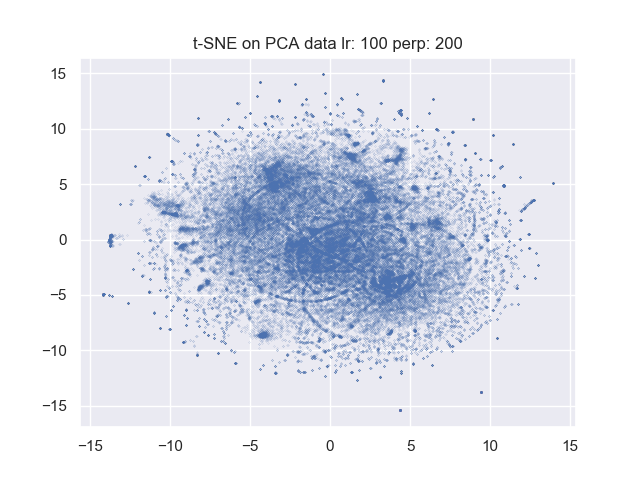

<IPython.core.display.Javascript object>


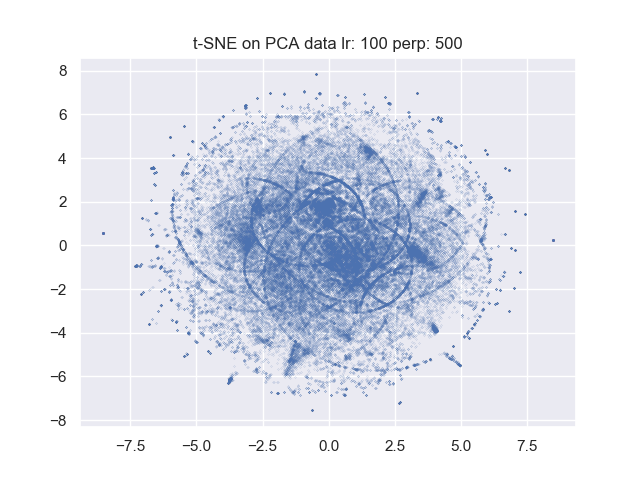

<IPython.core.display.Javascript object>


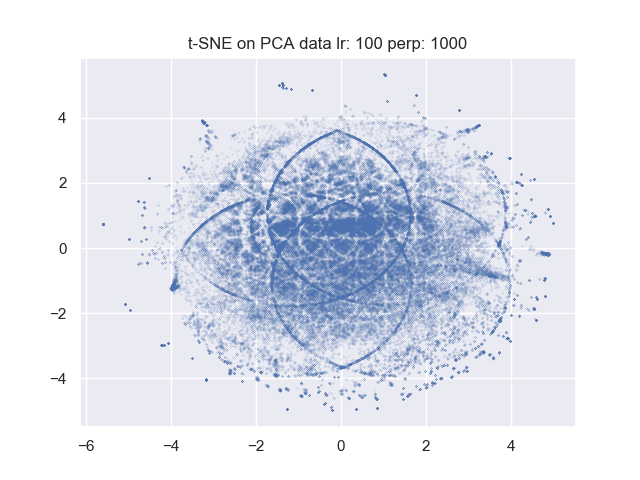

<IPython.core.display.Javascript object>


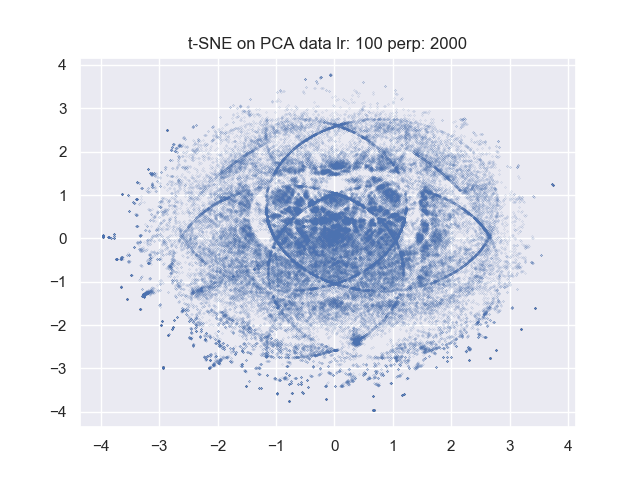

<IPython.core.display.Javascript object>


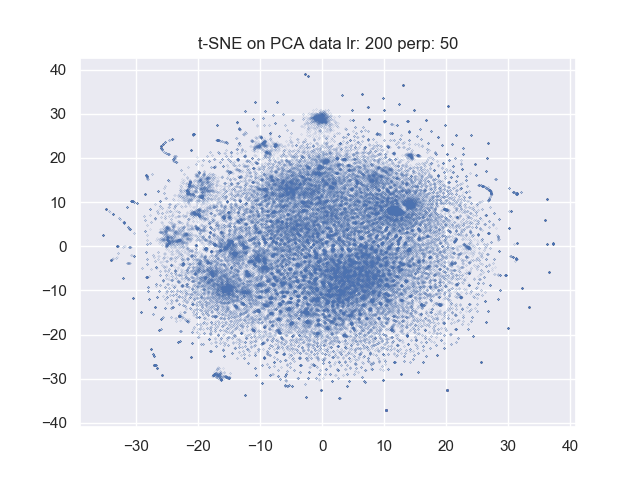

<IPython.core.display.Javascript object>


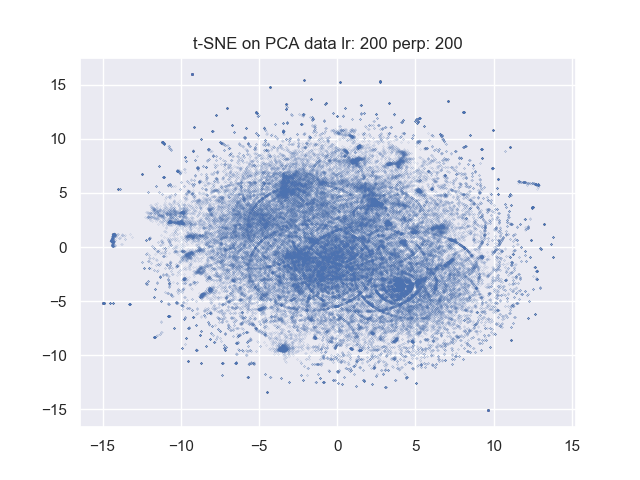

<IPython.core.display.Javascript object>


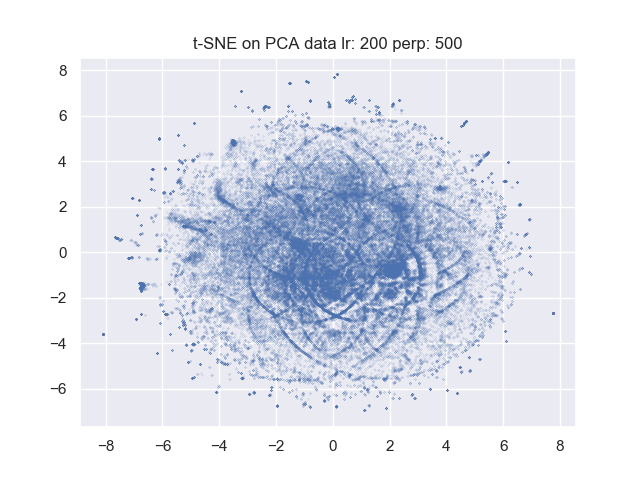

<IPython.core.display.Javascript object>


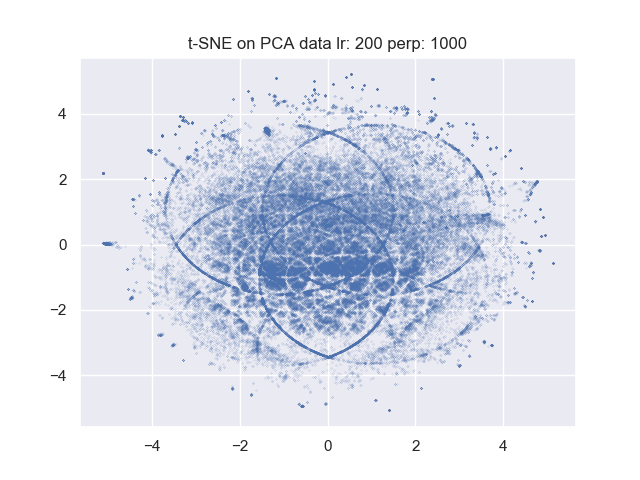

<IPython.core.display.Javascript object>


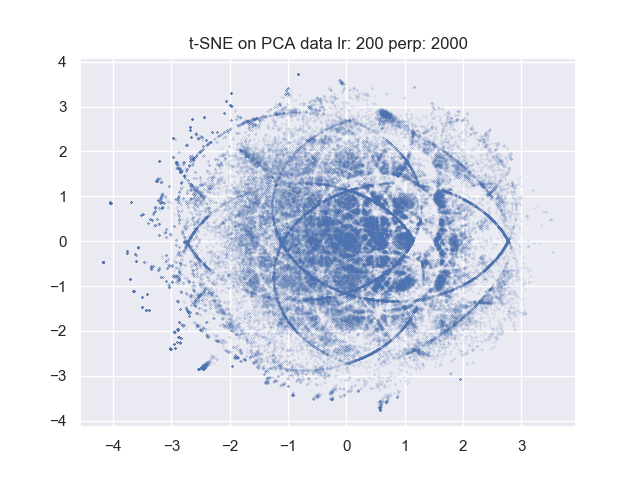

In [24]:
# plot t-SNE with PCA

for lr in lr_list:
    for perp in perp_list:     
        tsne_pca = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_pca_' + target_csv + '_' + str(lr) + '_' + str(perp) + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
        scatterplot_pointlabels(tsne_pca, 0.2)
        plt.title('t-SNE on PCA data lr: ' + str(lr) + ' perp: ' + str(perp) )
        plt.savefig(os.path.join(CONFIG.SVG_PATH, 'tsne_pca_' + target_csv + '_' + str(lr) + '_' + str(perp) + '.svg'))


In [32]:
#tsne_pca.to_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_' + target_dataset + '.csv'), encoding='utf-8-sig')
#tsne_pca = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_' + target_csv + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
tsne_pca = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_pca_latent_instagram0830_no_decode_200_50.csv'), index_col=0, header=0, encoding='utf-8-sig')
tsne_pca = tsne_pca.iloc[1:]
print(tsne_pca.iloc[:100])

                 tsne1      tsne2
B0-2hwnAUC7  18.543826  -0.657067
B0-3GYUJu9-   8.554574  11.331376
B0-9JKVFedH  14.296237   3.602698
B0-CPc3FpnC  11.160810 -18.864631
B0-D-SzhwCO -20.383673  -0.541305
B0-JKv-nxDa  -3.330551  -6.512248
B0-OOlUAdVQ  15.884987  18.018214
B0-QMh0lEHH  -5.528319  16.219497
B0-R0vhF4qE   8.608611  -4.422885
B0-WfPbHN_A  -3.430725  -8.600132
B0-duGsg4l_  22.629933   1.567070
B0-efNMhicQ  -0.661273 -17.394163
B0-nc4JpbWk  11.253627  -6.853258
B0-oremlziC   0.609086 -27.728579
B0-pN_rpCFd  -3.215551   8.173553
B0-qjKqh-lo -13.214627   3.358607
B0-t3ydB8-l -13.766277 -11.175381
B000ZR2HA_d   8.321988  -6.824670
B002rCih2i1  -6.446393  12.371748
B003Pl0jHO6   5.569315  -5.127342
B004iJVlmaC -10.739265  -2.699202
B006MJmATLE -12.301612  12.661214
B006s4zj4L3   9.241581  -7.563253
B00ANDNJMw1 -16.642393  -1.739577
B00B7rVpwmZ  21.538756  12.624386
B00CxNUgYzb  22.356912   3.282551
B00EdbCFZVH -14.842753   1.215490
B00GTGABoEy  14.226523  -0.393719
B00KZqRlx-S  1

In [ ]:
# on raw data
# TODO tune the learning rate and the iterations (rest should be ok i guess)
# start_time = time.time()
# tsne_raw = do_tsne(MulticoreTSNE(n_components=2, perplexity=400, early_exaggeration=12.0, learning_rate=100, n_iter=10000, random_state=42, n_jobs=4), data)
# print("time elapsed: " + str(time.time()-start_time))

In [ ]:
# plot t-SNE with raw data
# scatterplot_pointlabels(tsne_raw, plot_labels=False)
# plt.title('t-SNE on raw data')
# scatterplot_pointlabels(tsne_raw)
# plt.title('t-SNE on raw data')

## Spectral Clustering

In [ ]:
#temp
start_time = time.time()
temp_clustering = KMeans(n_clusters = 24, random_state=42).fit(df_normalized)
labels = temp_clustering.labels_
print("time elapsed for clustering: " + str(time.time()-start_time))
start_time = time.time()
print(silhouette_score(df_normalized, labels, metric = 'cosine'))
print("time elapsed for silhouette_score: " + str(time.time()-start_time))

In [17]:
def clustering_score(X, max_num_clusters=10):
    sse = []
    sil = []
    for k in range(2, max_num_clusters + 1):
        print("current cluster: " + str(k))
        start_time = time.time()
        temp_clustering = KMeans(n_clusters = k, random_state=42).fit(X)
        print("time elapsed for clustering: " + str(time.time()-start_time))
        labels = temp_clustering.labels_
        sse.append(temp_clustering.inertia_)
        start_time = time.time()
        sil.append(silhouette_score(X, labels))
        print("time elapsed for silhouette_score: " + str(time.time()-start_time))
    return sse, sil

In [13]:
def sse_distance(sse):
    distance = []
    last = len(sse) - 1
    for i in range(1, last):
        _distance = abs((sse[last] - sse[0]) * i - (last - 0) * sse[i] + last * sse[0] - sse[last] * 0) / math.sqrt(math.pow((sse[last] - sse[0]),2) + math.pow((last - 0),2))
        distance.append(_distance)
    return distance

current cluster: 2
time elapsed for clustering: 71.1085479259491
time elapsed for silhouette_score: 188.55522274971008
current cluster: 3
time elapsed for clustering: 81.46670722961426
time elapsed for silhouette_score: 186.160480260849
current cluster: 4
time elapsed for clustering: 93.18971276283264
time elapsed for silhouette_score: 185.31828904151917
current cluster: 5
time elapsed for clustering: 139.33593702316284
time elapsed for silhouette_score: 185.81729912757874
current cluster: 6
time elapsed for clustering: 134.30472874641418
time elapsed for silhouette_score: 183.44827032089233
current cluster: 7
time elapsed for clustering: 147.1406569480896
time elapsed for silhouette_score: 184.73183679580688
current cluster: 8
time elapsed for clustering: 166.21131587028503
time elapsed for silhouette_score: 185.26741433143616
current cluster: 9
time elapsed for clustering: 182.70027017593384
time elapsed for silhouette_score: 184.31695103645325
current cluster: 10
time elapsed for cl

<IPython.core.display.Javascript object>


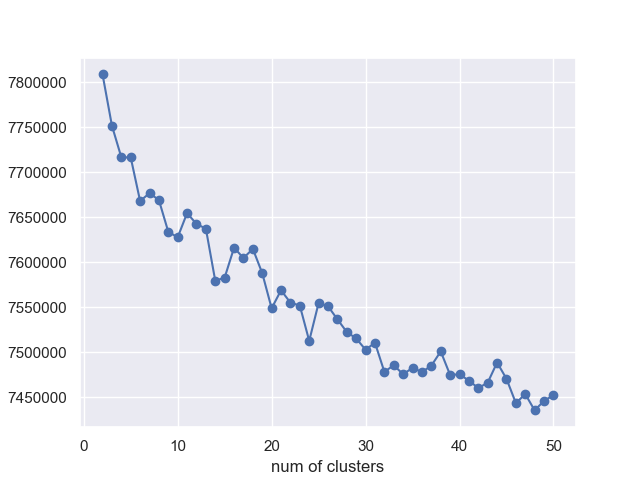

<IPython.core.display.Javascript object>


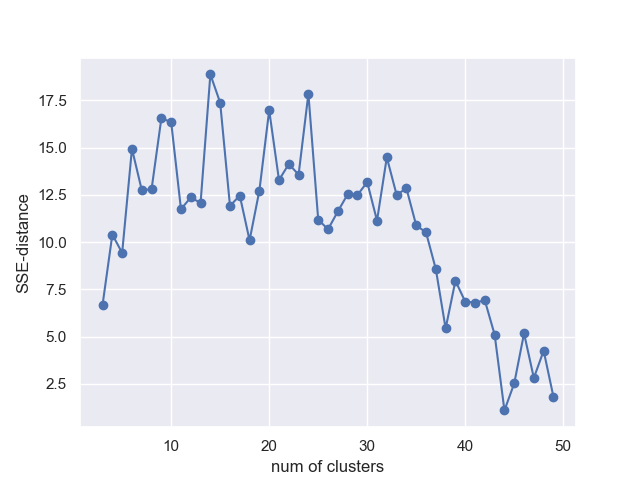

<IPython.core.display.Javascript object>


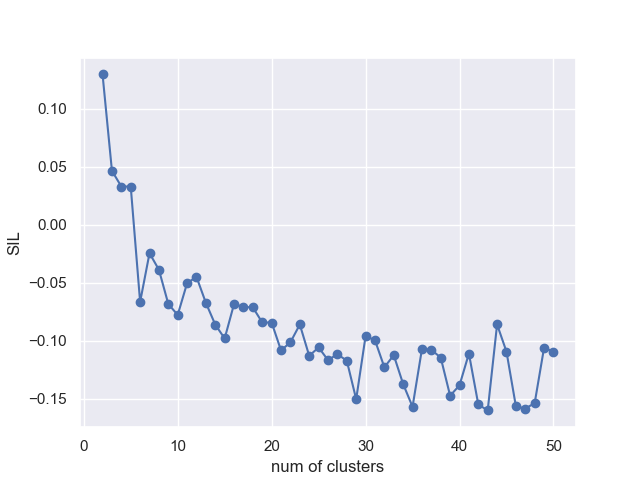

Text(0, 0.5, 'SIL')

In [18]:
max_num_clusters = 50
sse, sil = clustering_score(df_data, max_num_clusters)
fig = plt.figure()
plt.plot(range(2, max_num_clusters + 1), sse, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('SSE')
distance = sse_distance(sse)
fig = plt.figure()
plt.plot(range(3, max_num_clusters), distance, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('SSE-distance')
fig = plt.figure()
plt.plot(range(2, max_num_clusters + 1), sil, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('SIL')

In [25]:
num_clusters = 12

In [26]:
#labeling points of tnse clusters
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=3, fontproperties=fontprop1)

In [27]:
def count_percentage(cluster_labels):
    count = collections.Counter(cluster_labels)
    for k in count:
        print("cluster {} : {:.2%}".format(str(k), count[k]/len(cluster_labels)))

In [28]:
def do_clustering(df, tsne):
        start_time = time.time()
        #clustering = Birch(n_clusters=21).fit(df_data)
        #clustering = DBSCAN(eps=3, min_samples=5).fit(tsne_pca)
        #clustering = SpectralClustering(n_clusters=num_clusters, random_state=42).fit(df)
        #clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(data.loc[filtered_columns.index,:])# data, df_pca_data
        clustering = KMeans(n_clusters=num_clusters).fit(df)# data, df_pca_data
        count_percentage(clustering.labels_)
        print(clustering.labels_)
        print("time elapsed: " + str(time.time()-start_time))
        dist = copy.deepcopy(tsne)
        dist = dist.loc[df.index]
        dist['cluster'] = clustering.labels_
        return dist

In [33]:
#Spectral clustering
#For using 'amg' you should install pyamg in you local computer.
# Check the component at
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
clustered_df = do_clustering(df_data, tsne_pca)

cluster 9 : 31.75%
cluster 11 : 29.52%
cluster 4 : 22.77%
cluster 1 : 8.34%
cluster 2 : 3.82%
cluster 6 : 1.72%
cluster 3 : 0.98%
cluster 10 : 0.58%
cluster 8 : 0.01%
cluster 7 : 0.49%
cluster 0 : 0.02%
cluster 5 : 0.00%
[ 9 11 11 ...  9  9  1]
time elapsed: 335.86686420440674


In [43]:
result_df = pd.DataFrame(data=clustered_df['cluster'], index=clustered_df.index, columns=['cluster'])
result_df.to_csv(os.path.join(CONFIG.CSV_PATH, 'clustered_kmeans_' + target_csv + '.csv'), encoding='utf-8-sig')
#clustered_df = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'clustered_birch_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
print(clustered_df.iloc[:100])

                 tsne1      tsne2  cluster
short_code                                
B0-2hwnAUC7  18.543826  -0.657067        9
B0-3GYUJu9-   8.554574  11.331376       11
B0-9JKVFedH  14.296237   3.602698       11
B0-CPc3FpnC  11.160810 -18.864631        4
B0-D-SzhwCO -20.383673  -0.541305        9
B0-JKv-nxDa  -3.330551  -6.512248        1
B0-OOlUAdVQ  15.884987  18.018214        2
B0-QMh0lEHH  -5.528319  16.219497        1
B0-R0vhF4qE   8.608611  -4.422885        4
B0-WfPbHN_A  -3.430725  -8.600132        4
B0-duGsg4l_  22.629933   1.567070        9
B0-efNMhicQ  -0.661273 -17.394163       11
B0-nc4JpbWk  11.253627  -6.853258        4
B0-oremlziC   0.609086 -27.728579        2
B0-pN_rpCFd  -3.215551   8.173553        9
B0-qjKqh-lo -13.214627   3.358607        9
B0-t3ydB8-l -13.766277 -11.175381        4
B000ZR2HA_d   8.321988  -6.824670        9
B002rCih2i1  -6.446393  12.371748        9
B003Pl0jHO6   5.569315  -5.127342        9
B004iJVlmaC -10.739265  -2.699202       11
B006MJmATLE

In [44]:
def plot_spectral_clustering(dataframe, markersize=None):
    # plot spectrac clustering result
    # without label
    #scatterplot_pointlabels(dataframe[['x', 'y']], markersize)
    # better colors
    plt.figure()
    color_dict = {v: k for v, k in enumerate(sns.color_palette("Paired", num_clusters))}
    sns_plot = sns.scatterplot(x="x", y="y", hue='cluster_id', palette=color_dict, data=dataframe, marker='.', s=markersize)
    plt.savefig(os.path.join(CONFIG.SVG_PATH, 'clustering_' + target_csv + '.svg'))

<IPython.core.display.Javascript object>


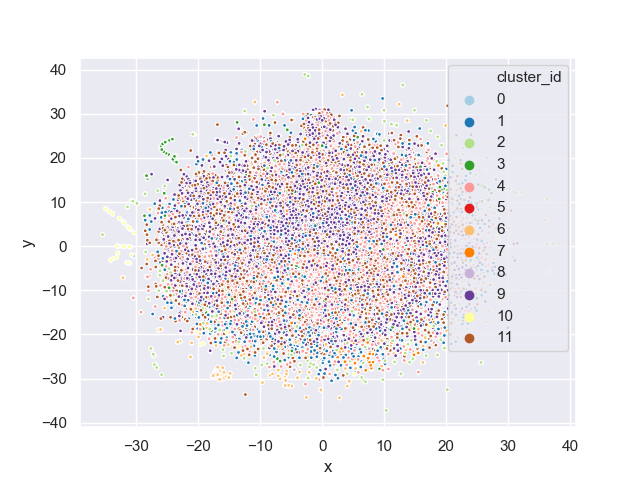

In [45]:
# put clustering info into df
df_clustered_spectral = pd.DataFrame({'x': clustered_df.tsne1.squeeze(), 
                                      'y': clustered_df.tsne2.squeeze(), 
                                      'cluster_id': clustered_df.cluster.squeeze()})
# debug prints
#print(df_clustered_spectral.dtypes)
plot_spectral_clustering(df_clustered_spectral, 30)       
#ds_clustered_spectral = downsampling(df_clustered_spectral, 5000)
#plot_spectral_clustering(ds_clustered_spectral, 0.2)       
# print(df_clustered_spectral.iloc[:10, :])
# df_clustered_spectral['cluster_id'].describe() # 30 integer clusters